# Data Processing Notebook
This template script contains all the code needed to import and process Raman spectra, then save them in a standardised file format. It can import and process a single file, or multiple files at once. Available processing includes:
- Averaging for multi-spec measurements
- Baseline (background) subtraction
- Reference spectrum subtraction
- Automatic peak detection
- Automatic peak fitting

# Requires input data files to be organised as follows:
- Location: {Data_dir}/{Sample}/{Measurement Date}/
- Sample/Measurement metadata must be recorded in either file {spec filename}_MetaData.csv, or within spec filename
    - Spec filename format:
    
        {Spec ID number}\_{Instrument Name}\_{Component1}-{Component1 concentration}\_{Component2}-{Component2 concentration}.txt
    
    - For mixtures containing more than 2 components, add additional \_{Component}-{concentration} pairs to the filename.
    - Each spectrum file in a given project must have a unique identifier (preferable a sequential ID number) so that it can always be distinguished from other measurements, even when they are otherwise identical. These ID numbers can be used to refer to particular spectra when manually specifying settings to use for outliers/exceptional cases.
    - any pre-processing steps applied to the data should be included at the end of the filename
        - C: cosmic ray removal
        - O: outlier removal
        - N: normalisation
        
# How to use this script:
- Pick your directories and specify what sample/setting filters you want to apply when importing files
- Adjust the data import string to make sure it matches your file structure and naming conventions (if necessary)
- Each section of code starts with a set of user input variables to control what it does:

             skip: skip this section entirely (True/False)
            debug: print debug messages during execution (True/False)
        show_plot: show plotted figures in viewer (True/False)
        save_plot: save plotted figures to file (True/False)
        
    Data processing sections also need to be told what x,y values and keynames to use for input/output:
    
            x_key: the keyname to use as x values (e.g. 'raman_shift')
            y_key: the keyname to use as y values (e.g. 'y_av_sub')
          alt_key: the back-up keyname to use as y values if y_key does not exist for a given measurement (e.g. 'y_av')
          new_key: the keyname to save the output under (e.g. 'y_av_refsub' or 'fitted_peaks')
          
    Some processing steps also have manual overrides, for example if you want to specify what measurements need to have a reference spectrum subtracted, or which peak positions to fit for a given measurement. Please refer to those sections.

- To turn off/on sections of code, e.g. peak detection, simply use the 'skip' variable at the start of each section.
- When rerunning sections of code, bear in mind that data and variables will reflect the most recent state and may give you unexpected results - sometimes it's safer to rerun the whole script. 
- When you are happy with the output of a particular section, you can switch the 'debug' variable to False to hide debug text generated in the window. It will continue to show key information, and plots.
- To save time and memory, you can switch 'show_plot' to False to stop plots being rendered in the viewer. They will still be saved to disk if 'save_plot' is True.


In [1]:
# ==================================================
# define where your data is, and what files to import

# list directories for input data, figures and output files
Data_dir = './data/'
Fig_dir = './figures/'
Out_dir = './output/'
Ref_dir = './data/Standards/'

Technique = 'Raman'         # 'Raman' or 'FTIR'

# filter data import by sample / subsample
Instrument = 'MOBIUS'           # name of nstrument
Mixture = 'dGTP_Na2SO4_H2O'     # name of sample, or '*' for all

# list of filenames not to import
Do_Not_Import = []

Components = Mixture.split("_")

Laser_Wavelength = '248'        # wavelength in nm, as str

In [2]:
# ==================================================
# this section imports necessary python modules

import os
import math
import glob
import datetime
import numpy as np
import pandas as pd
import lmfit as lmfit
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter

# import VibSpec module functions
from OSTRI_functions import *

"""
# ==================================================
# FILE SEARCH
# - this section searches for spectrum files that match the specified settings
# ==================================================
"""

print("SEARCHING FOR SPECTRUM DATA FILES...")

# find files
#   - currently requires data files to be named and organised as follows:
# Data_dir/{Sample}/{Measurement_Date}/{Measurement_ID}_{Sample}_{Subsample}_{Measurement Parameters}.txt
text = "%s%s/%s_*.txt" % (Data_dir, Mixture, Instrument)
print(text)
spec_dirs = sorted(glob.glob(text))

# for each file, get components and concentrations for sorting
mixtures = []
conc_ratios = []
for file in spec_dirs:
    while True:
        try:
            temp = file.split("/")[-1][:-4].split("_")[1:]
            components = {}
            for item in temp:
                comp, val = item.split("-")
                for i, c in enumerate(val):
                    if c not in '0123456789.':
                        conc = float(val[:i])
                        unit = val[i:]
                        break
                # standardise units to ppm
                if unit == 'wt':
                    conc_ppm = conc * 1000000. / 100.
                elif unit == 'mM':
                    conc_ppm = conc * 1000000. / 55510.
                components[comp] = conc_ppm
            conc_ratio = np.float64(components[Components[0]]) / np.float64(components[Components[1]])
            mixtures.append("_".join(list(components.keys())))
            conc_ratios.append(conc_ratio)
            break
        except Exception as e:
            print("something went wrong! Exception:", e)
            break
            
# sort by mixture and concentration ratio
sort = np.lexsort((conc_ratios, mixtures))
spec_dirs = np.asarray(spec_dirs)[sort]

print("data files found:", len(spec_dirs))
for file in spec_dirs:
    print("    ", file.split("/")[-1])
    comps = file.split("/")[-1][:-4].split("_")[1:]
    for comp in comps:
        comp, conc = comp.split("-")
        print("        %10s: %10s" % (comp, conc))

SEARCHING FOR SPECTRUM DATA FILES...
./data/dGTP_Na2SO4_H2O/MOBIUS_*.txt
data files found: 7
     MOBIUS_dGTP-0.01mM_Na2SO4-99.99mM_H2O-55510mM.txt
              dGTP:     0.01mM
            Na2SO4:    99.99mM
               H2O:    55510mM
     MOBIUS_dGTP-0.05mM_Na2SO4-99.95mM_H2O-55510mM.txt
              dGTP:     0.05mM
            Na2SO4:    99.95mM
               H2O:    55510mM
     MOBIUS_dGTP-0.1mM_Na2SO4-99.9mM_H2O-55510mM.txt
              dGTP:      0.1mM
            Na2SO4:     99.9mM
               H2O:    55510mM
     MOBIUS_dGTP-0.5mM_Na2SO4-99.5mM_H2O-55510mM.txt
              dGTP:      0.5mM
            Na2SO4:     99.5mM
               H2O:    55510mM
     MOBIUS_dGTP-1mM_Na2SO4-99mM_H2O-55510mM.txt
              dGTP:        1mM
            Na2SO4:       99mM
               H2O:    55510mM
     MOBIUS_dGTP-10mM_Na2SO4-90mM_H2O-55510mM.txt
              dGTP:       10mM
            Na2SO4:       90mM
               H2O:    55510mM
     MOBIUS_dGTP-50mM_Na2SO4-50mM_

# Data import

- this section actually imports data files and extracts their metadata
- metadata can be in a separate CSV file with the same name plus '\_metadata', or can be extracted from the data file's name
- measurements are imported file by file, and added sequentially to the 'data' dict
- to access a specific measurement, you call data\[measurement ID\]\[key\], where 'key' is the type of data you want from it

IMPORTING DATA...

importing MOBIUS_dGTP-0.01mM_Na2SO4-99.99mM_H2O-55510mM
['dGTP-0.01mM', 'Na2SO4-99.99mM', 'H2O-55510mM']
              dGTP: 1.0E-02 mM - 1.8E-01 ppm
            Na2SO4: 1.0E+02 mM - 1.8E+03 ppm
               H2O: 5.6E+04 mM - 1.0E+06 ppm
evaluated conc. ratio: 1.0E-04 dGTP/Na2SO4
    spec array: (26, 1024)
    spectral map, 25 points
              shift: (1024,)
          intensity: (1024, 25)
        shift range: 573 - 4252 cm-1
         inf check: 0/1024
         nan check: 0/1024
        zero check: 0/1024
    imported successfully!

importing MOBIUS_dGTP-0.05mM_Na2SO4-99.95mM_H2O-55510mM
['dGTP-0.05mM', 'Na2SO4-99.95mM', 'H2O-55510mM']
              dGTP: 5.0E-02 mM - 9.0E-01 ppm
            Na2SO4: 1.0E+02 mM - 1.8E+03 ppm
               H2O: 5.6E+04 mM - 1.0E+06 ppm
evaluated conc. ratio: 5.0E-04 dGTP/Na2SO4
    spec array: (26, 1024)
    spectral map, 25 points
              shift: (1024,)
          intensity: (1024, 25)
        shift range: 573 - 4252 cm-1


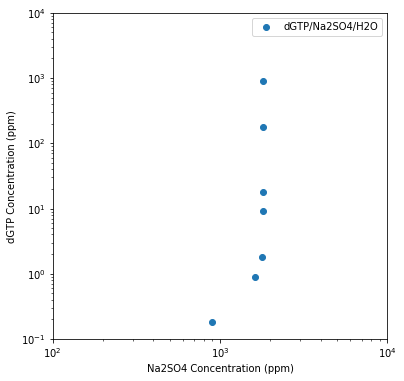


laser wavelengths in dataset:
     248 nm


In [3]:
print("IMPORTING DATA...")

# print debug messages?
debug = True

# set up data storage dictionary
data = {}

# ==================================================
# each measurement imported will be added to this dictionary as a Measurement object
# To access a particular measurement, use data[measurement ID]

# for each detected file
count = 0
for spec_dir in spec_dirs:
    while True:
        try:
            filename = spec_dir.split("/")[-1][:-4]
            ID = count
            if filename in Do_Not_Import:
                print()
                print(" measurement %s is in Do_Not_Import list, skipping" % filename)
                break
            else:
                print()
                print("importing %s" % filename)
                # extract sample/measurement metadata
                instrument = filename.split("_")[0]
                temp = filename.split("_")[1:]
                print(temp)
                components = {}
                for item in temp:
                    comp, val = item.split("-")
                    for i, c in enumerate(val):
                        if c not in '0123456789.':
                            conc = float(val[:i])
                            unit = val[i:]
                            break
                    # standardise units to ppm
                    if unit == 'wt':
                        conc_ppm = conc * 1000000. / 100.
                    elif unit == 'mM':
                        conc_ppm = conc * 1000000. / 55510.
                    components[comp] = conc_ppm
                    print("        %10s: %0.1E %s - %0.1E ppm" % (comp, conc, unit, conc_ppm))
                conc_ratio = components[Components[0]]/components[Components[1]]
                print("evaluated conc. ratio: %0.1E %s/%s" % (conc_ratio, Components[0], Components[1]))
                # import spectrum file (assumes Renishaw file formatting with either 2 or 4 columns)
                if instrument == 'MOBIUS':
                    # expect 2D array
                    spec = np.genfromtxt(spec_dir, delimiter='\t')
                    if np.size(spec, axis=0) in [1024,1025,2048]:
                        spec = spec.transpose()
                    if np.size(spec, axis=1) == 1025:
                        spec = spec[:,:-1]
                    if debug == True:
                        print("    spec array:", np.shape(spec))
                    xy_coords = np.asarray([[0],[0]])
                    points = np.size(spec, axis=0)-1
                    if points > 1:
                        spec_type = 'map'
                        print("    spectral map, %s points" % (points))
                    else:
                        spec_type = 'point'
                        print("    single point measurement")
                    x = spec[0]
                    y = spec[1:]
                    sort = np.argsort(x)
                    x = x[sort]
                    y = y.transpose()[sort,:]
                        
                else:
                    # assume Renishaw file, expect either single spec (shift,intensity) or multi-spec (X,Y,shift,intensity)
                    spec = np.genfromtxt(file, delimiter=',', skip_header=1).transpose()
                    if debug == True:
                        print("    spec array:", np.shape(spec))
                    distances = []
                    xy_coords = []
                    if np.size(spec, axis=0) == 4:
                        # map or line, columns=(x_position, y_position, raman_shift, intensity)
                        spec_type = 'map'
                        # determine splits between stacked spectra
                        splits = np.ravel(np.where(np.roll(spec[2], 1) < spec[2]))
                        points = len(splits)
                        print("    spectral map, %s points" % (points))
                        # get X,Y coordinates (in um) for each point spectrum
                        x_pos = np.asarray(spec[0][splits])
                        y_pos = np.asarray(spec[1][splits])
                        xy_coords = np.asarray([x_pos, y_pos])
                        # determine if line, or map by looking at signs of dX, dY
                        dx = np.roll(x_pos, 1)[1:] - x_pos[1:]
                        dy = np.roll(y_pos, 1)[1:] - y_pos[1:]
                        dx_sign = np.sign(dx)
                        dy_sign = np.sign(dy)
                        if np.all(dx_sign == np.sign(np.mean(dx))) & np.all(dy_sign == np.sign(np.mean(dy))):
                            # checks if points follow a line
                            print("    measurement is a 1D line scan")
                            spec_type = 'line'
                            distances = np.cumsum(np.sqrt(dx**2 + dy**2))
                            distances = np.insert(distances, 0, 0)
                        else:
                            # assumes points are arranged in a grid
                            print("    measurement is a 2D map scan")
                        # extract shift, intensity spectrum for each point
                        x = np.asarray(np.split(spec[2], splits[1:]))[0]
                        y = np.asarray(np.split(spec[3], splits[1:]))
                    else:
                        # single point, columns=(raman_shift, intensity)
                        spec_type = 'point'
                        points = 1
                        xy_coords = np.asarray([[0],[0]])
                        print("        single point measurement")
                        x = spec[0]
                        y = spec[1:]
                    sort = np.argsort(x)
                    x = x[sort]
                    y = y.transpose()[sort,:]
                infcheck = np.any(np.isinf(y), axis=1)
                nancheck = np.any(np.isnan(y), axis=1)
                zerocheck = np.any(y == 0, axis=1)
                check = np.logical_or.reduce((infcheck, nancheck, zerocheck))
                if debug == True:
                    print("              shift:", np.shape(x))
                    print("          intensity:", np.shape(y))
                    print("        shift range: %0.f - %0.f cm-1" % (np.amin(x), np.amax(x)))
                    print("         inf check: %0.f/%0.f" % (np.count_nonzero(infcheck),
                                                               np.size(infcheck)))
                    print("         nan check: %0.f/%0.f" % (np.count_nonzero(nancheck),
                                                               np.size(nancheck)))
                    print("        zero check: %0.f/%0.f" % (np.count_nonzero(zerocheck),
                                                               np.size(zerocheck)))
                if np.count_nonzero(check) > 0.1 * np.size(check):
                    raise Exception("%0.f%% of spectrum data is 0/nan/inf! Cannot import!" % (100*np.count_nonzero(check)/np.size(check)))
                # get average spectrum (for single points, just use spec)
                y_av = np.mean(y, axis=0)
                # generate sample title for consistent naming
                title = "_".join(filename.split("_")[1:])
                # define name for output folder structure
                output_folder = '%s/%s/' % ("_".join(components.keys()), filename)
                # create Measurement instance from imported data
                data[str(ID)] = Measurement(
                    ID=str(ID),
                    title=title,
                    filename=filename,
                    sample="/".join(Mixture.split("_")),
                    components=components,
                    conc_ratio=conc_ratio,
                    x=x[~check],
                    y=y[~check],
                    spec_type=spec_type,
                    points=points,
                    ykey='y',
                    technique='Raman',
                    instrument=instrument,
                    laser_wavelength=Laser_Wavelength,
                    generate_average=True,
                    x_coords=xy_coords[0],
                    y_coords=xy_coords[1],
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir,
                    output_folder = output_folder
                )
                
                count += 1
                print("    imported successfully!")
                break
        except Exception as e:
            print("    something went wrong! Exception:", e)
            break
        
print()
print("%s/%s files imported" % (len(data.keys()), len(spec_dirs)))

# update list of Spec IDs to only include imported spectra
Spec_IDs = list(data.keys())

mixtures = np.unique([data[ID]['sample'] for ID in Spec_IDs])
print()
print("mixtures in dataset:")
plt.figure(figsize=(6,6))
for i, mixture in enumerate(mixtures):
    print("    ", mixture)
    print("        samples:", len([data[ID]['sample'] == mixture for ID in Spec_IDs]))
    print("          concs:")
    A_concs = np.sort([data[ID]['components'][Components[0]] for ID in Spec_IDs])
    B_concs = np.sort([data[ID]['components'][Components[1]] for ID in Spec_IDs])
    for conc in A_concs:
        print("            %0.1E ppm" % conc)
    plt.scatter(B_concs, A_concs, label=mixture)
x_min = 10**np.floor(0.9*np.log10(np.nanmin(B_concs)))
x_max = 10**np.ceil(1.1*np.log10(np.nanmax(B_concs)))
y_min = 10**np.floor(0.9*np.log10(np.nanmin(A_concs)))
y_max = 10**np.ceil(1.1*np.log10(np.nanmax(A_concs)))
plt.xscale('log')
plt.xlim(x_min, x_max)
plt.yscale("log")
plt.ylim(y_min, y_max)
plt.xlabel("%s Concentration (ppm)" % Components[1])
plt.ylabel("%s Concentration (ppm)" % Components[0])
plt.legend()
plt.show()


lasers = np.unique([measurement.laser_wavelength for ID, measurement in data.items()])
print()
print("laser wavelengths in dataset:")
for laser in lasers:
    print("    ", laser, "nm")

# Baseline Subtraction
- baseline is a polynomial fitted to specified points along the x axis
- you can specify the points and polynomial order used for each wavelength, and add additional logic for specific samples if needed
- subtract_baseline() function finds the local average for each point ±25 cm-1, this value can be changed using the window argument
- automatically baselines each spectrum in a multi-spec measurement separately, individual spectra are stored in y_sub\[measurement index\]\[spec index\]
- y_av_sub is the baselined average spectrum
- y_sub_av is the average of the baselined spectra

DOING BASELINE SUBTRACTION

1/7 subtracting baseline for dGTP-0.01mM_Na2SO4-99.99mM_H2O-55510mM
    dGTP: 0.18014772113132768 ppm
    Na2SO4: 1801.2970635921456 ppm
    H2O: 1000000.0 ppm
points for baselining: [ 900 1100 1250 1400 1800 1900 2400 2500 2600 3900 4000 4100 4200]


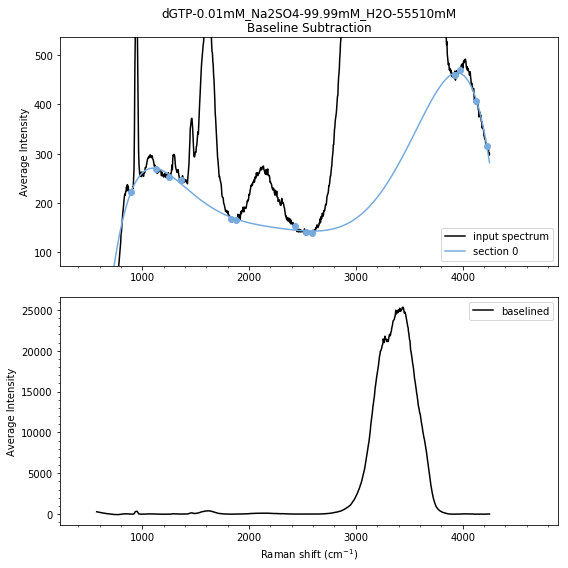

(1024, 25)


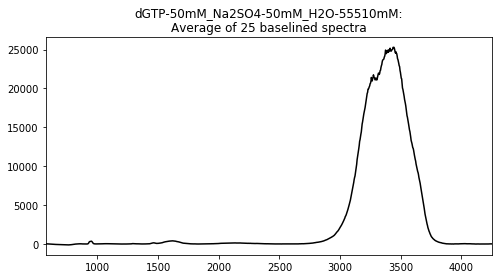

    baseline subtracted!

2/7 subtracting baseline for dGTP-0.05mM_Na2SO4-99.95mM_H2O-55510mM
    dGTP: 0.9007386056566384 ppm
    Na2SO4: 1800.5764727076203 ppm
    H2O: 1000000.0 ppm
points for baselining: [ 900 1100 1250 1400 1800 1900 2400 2500 2600 3900 4000 4100 4200]


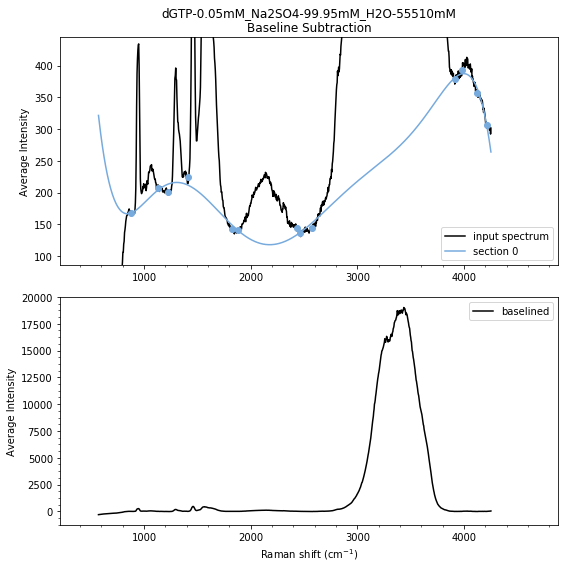

(1024, 25)


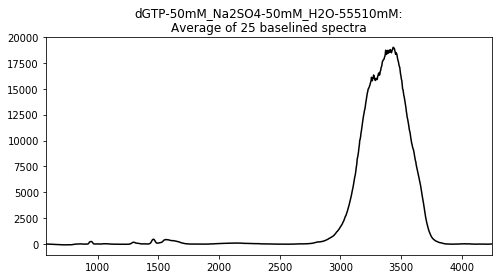

    baseline subtracted!

3/7 subtracting baseline for dGTP-0.1mM_Na2SO4-99.9mM_H2O-55510mM
    dGTP: 1.8014772113132769 ppm
    Na2SO4: 1799.6757341019636 ppm
    H2O: 1000000.0 ppm
points for baselining: [ 900 1100 1250 1400 1800 1900 2400 2500 2600 3900 4000 4100 4200]


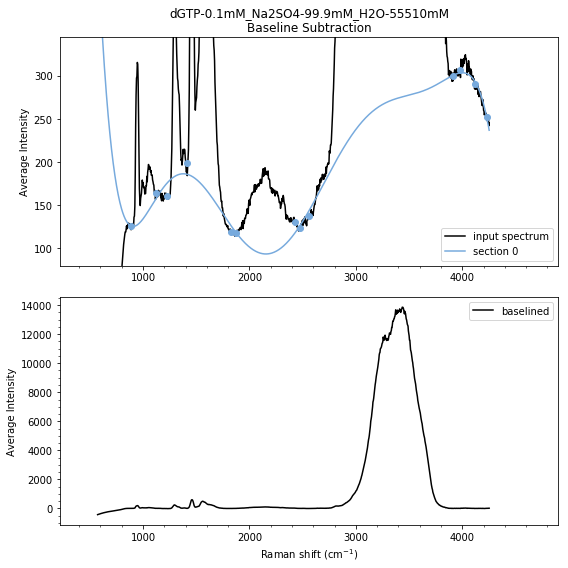

(1024, 25)


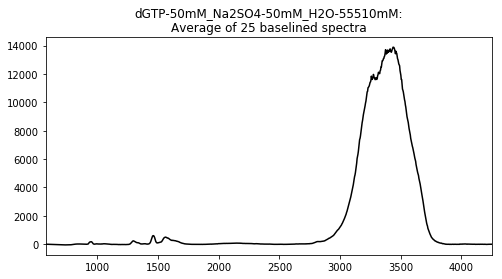

    baseline subtracted!

4/7 subtracting baseline for dGTP-0.5mM_Na2SO4-99.5mM_H2O-55510mM
    dGTP: 9.007386056566384 ppm
    Na2SO4: 1792.4698252567105 ppm
    H2O: 1000000.0 ppm
points for baselining: [ 900 1100 1250 1800 1900 2100 2300 2400 2500 3900 4000 4100 4200]


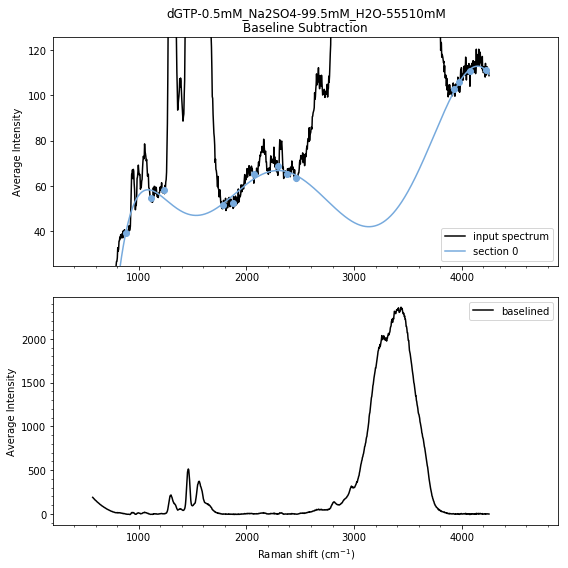

(1024, 25)


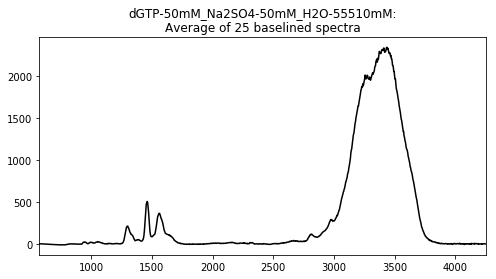

    baseline subtracted!

5/7 subtracting baseline for dGTP-1mM_Na2SO4-99mM_H2O-55510mM
    dGTP: 18.014772113132768 ppm
    Na2SO4: 1783.4624392001442 ppm
    H2O: 1000000.0 ppm
points for baselining: [ 900 1100 1250 1800 1900 2100 2300 2400 2500 3900 4000 4100 4200]


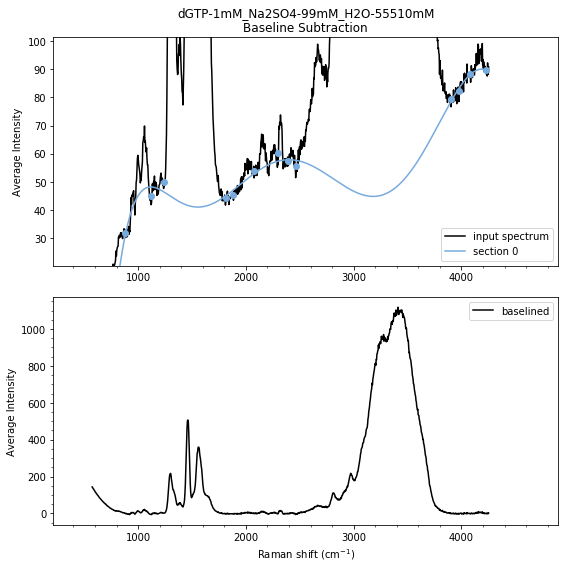

(1024, 25)


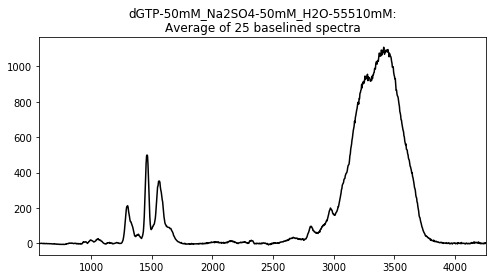

    baseline subtracted!

6/7 subtracting baseline for dGTP-10mM_Na2SO4-90mM_H2O-55510mM
    dGTP: 180.1477211313277 ppm
    Na2SO4: 1621.3294901819493 ppm
    H2O: 1000000.0 ppm
points for baselining: [ 900 1100 1250 1800 1900 2100 2300 2400 2500 3900 4000 4100 4200]


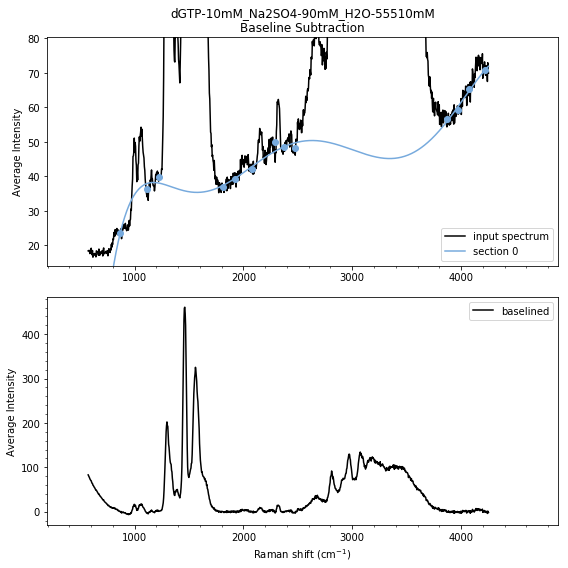

(1024, 25)


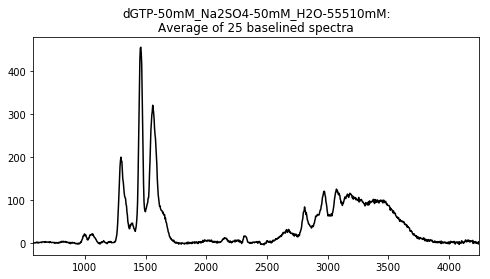

    baseline subtracted!

7/7 subtracting baseline for dGTP-50mM_Na2SO4-50mM_H2O-55510mM
    dGTP: 900.7386056566385 ppm
    Na2SO4: 900.7386056566385 ppm
    H2O: 1000000.0 ppm
points for baselining: [ 900 1100 1250 1800 1900 2100 2300 2400 2500 3900 4000 4100 4200]


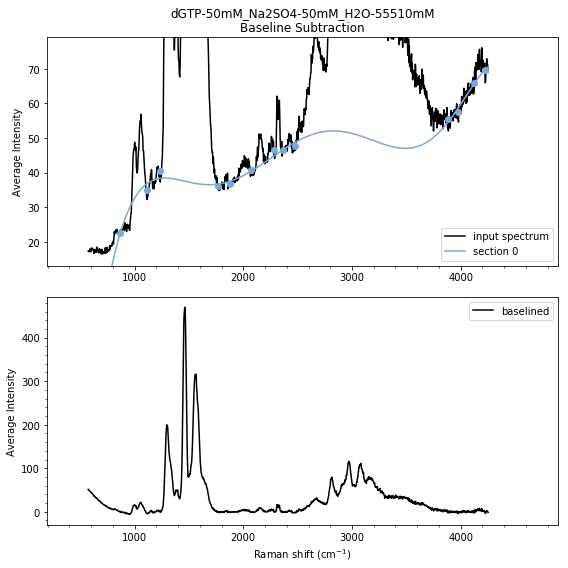

(1024, 25)


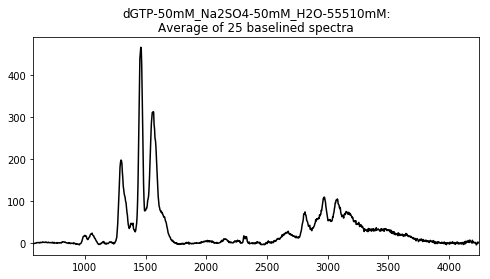

    baseline subtracted!


In [4]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = False

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use ('y_av')
y_key = 'y_av'

# new keyname for baselined spectrum
new_key = 'y_av_sub'

# x positions to use for fitting baseline
base_list = []

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING BASELINE SUBTRACTION")
    print("    (not recommended for Raman spectra)")
else:
    print("DOING BASELINE SUBTRACTION")

    process_count = 1
    for ID, measurement in data.items():
        print()
        print("%s/%s subtracting baseline for %s" % (process_count, len(data.keys()), measurement.title))
        # decide which set of baseline points to use
        comps = list(measurement.components.keys())
        for comp, conc in measurement.components.items():
            print("    %s: %s ppm" % (comp, conc))
        if 'dATP' in comps:
            base_list = [900, 1050, 1100, 1700, 1800, 1900, 2400, 2500]
            if measurement.components['dATP'] < 5:
                base_list += [1400, 2600]
            elif measurement.components['dATP'] > 100:
                base_list += [2100, 2300, 3050]
            else:
                base_list += [2100, 2300, 2900]
            if 'H2O' in comps:
                base_list += [3900, 4000, 4100, 4200]
        elif 'dCTP' in comps:
            base_list = [900, 1050, 1100, 1300, 1800, 1900, 2400, 2500]
            if measurement.components['dCTP'] < 5:
                base_list += [1400, 2600]
            else:
                base_list += [2100, 2300, 2900]
            if 'H2O' in comps:
                base_list += [2700, 3900, 4000, 4100, 4200]
        elif 'dGTP' in comps:
            base_list = [900, 1100, 1250, 1800, 1900, 2400, 2500]
            if measurement.components['dGTP'] < 5:
                base_list += [1400, 2600]
            else:
                base_list += [2100, 2300]
            if 'H2O' in comps:
                base_list += [3900, 4000, 4100, 4200]
        elif 'dTTP' in comps:
            base_list = [900, 1050, 1100, 1250, 1300, 1800, 1900, 2400, 2500]
            if 'H2O' in comps:
                base_list += [2700, 3900, 4000, 4100, 4200]
        elif '13DHN' in comps:
            base_list = [400, 800, 1800, 2000, 2200, 2500, 2700, 2900, 3000, 3100]
        elif 'IOM' in comps and '9MA' in comps:
            base_list = [400, 800, 900, 1800, 2000, 2200, 2500, 2700, 2900, 3000, 3100]
        elif 'IOM' in comps:
            base_list = [400, 800, 900, 1480, 1800, 2000, 2200, 2500, 2700, 2900, 3000, 3100]
        elif 'CaSO4' in comps:
            base_list = [400, 750, 800, 900, 1800, 2000, 2200, 2500, 2900, 2700, 3000, 3100]
        else:
            base_list = [400, 800, 1080, 1800, 2000, 2200, 2500, 2700, 2900, 3000, 3100]
        order = int(len(base_list)/1.5)
        
        base_list = np.sort(np.asarray(base_list))
        print("points for baselining:", base_list)

        # subtract baseline from average spectrum
        subtract_baseline(measurement, x_key, y_key, new_key, base_list, base='polynomial', order=order,
                          fixed_ends=False, show_plot=show_plot, save_plot=save_plot, debug=debug)

        # baseline individual spectra if necessary
        if measurement.points > 1:
            if debug == True:
                print("%s points:" % title, measurement.points)
                print("    map x,y arrays:", np.shape(measurement['raman_shift']), np.shape(measurement['y']))
            # subtract baseline from individual spectra
            subtract_baseline(measurement, x_key, 'y', 'y_sub', base_list, base='poly', order=order,
                              fixed_ends=True, show_plot=False, save_plot=False, debug=debug)
            
            if show_plot == True:
                # plot average of baselines vs baseline of average
                plt.figure(figsize=(8,4))
                plt.title("%s:\nAverage of %s baselined spectra" % (title, measurement.points))
                ### need to add st.dev. handling to make this work
                ### plt.fill_between(spec['raman_shift'], np.mean(spec['y_sub'], axis=0)-np.std(spec['y_sub'],axis=0),
                        ### np.mean(spec['y_sub'], axis=0)+np.std(spec['y_sub'], axis=0), color='k', alpha=0.1, linewidth=0.)
                print(np.shape(measurement['y_sub'].y))
                plt.plot(measurement['raman_shift'], measurement['y_sub'].mean(), 'k')
                plt.xlim(measurement.x_start, measurement.x_end)
                plt.show()

            # get average of baselined spectra
            log = measurement['y_sub'].log + ['averaged over %s spectra' % measurement.points]
            measurement.add_spectrum(key='y_sub_av', y=measurement['y_sub'].mean(),
                    label='Averaged Baselined Intensity (counts)', log=log)
        process_count += 1
        print("    baseline subtracted!")

# Reference Spectrum Subtraction
- for specified spectra, subtract named reference spectrum
- works by interpolating reference spectrum to match target spectrum, rescaling reference spectrum to fit target spectrum at key positions, then subtracting reference from target
- requires processed reference spectrum to be in ./{Output_dir}/
- y_av_sub is the baselined average spectrum
- y_sub_av is the average of all baselined spectra

In [5]:
# skip this section?
skip = True

# print debug messages in viewer?
debug = True

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use - defined for each reference in subtraction_refs dict

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# keyname for new spectrum
new_key = 'y_av_sub_refsub'

# for each reference spectrum being used, add its spec ID to this dict as follows:
# ref ID: {
#   'name': 'glass', # name of reference
#   'targets': [],  # list of spec IDs to subtract this reference from
#   'x_list': []    # list of x positions to fit when rescaling reference to match y values of target
# }
subtraction_refs = {
}

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING REF SPECTRA IMPORT")
else:
    print("DOING REF SPECTRA IMPORT")
    
    # data storage array for reference spectra
    ref_data = {}
    
    # check which references need to be imported
    refs_for_import = []
    for ref, ref_info in subtraction_refs.items():
        targets = ref_info['targets']
        check = np.any(np.asarray([target in Spec_IDs for target in targets]))
        if check == True:
            refs_for_import.append(ref)

    print()
    print("references to import:")
    for ref_ID in refs_for_import:
        print("    ", ref_ID)

    # import processed reference spectra
    for ref_ID in refs_for_import:
        # get info from dict
        ref_name = subtraction_refs[ref_ID]['name']
        targets = [target for target in subtraction_refs[ref_ID]['targets'] if target in Spec_IDs]
        x_list = subtraction_refs[ref_ID]['x_list']
        rerun = subtraction_refs[ref_ID]['rerun_baseline']
        add_poly = subtraction_refs[ref_ID]['add_polynomial']
        poly_order = subtraction_refs[ref_ID]['poly_order']
        key = subtraction_refs[ref_ID]['key']
        print()
        print("reference:", ref_ID, ref_name)
        print("    to be subtracted from:", targets)
        print("    x_list for fitting:", x_list)
        # check if ref is in imported data
        success = False
        if ref_ID in Spec_IDs:
            # use currently-imported spectrum if possible
            if hasattr(data[str(ref_ID)], 'y_av_sub'):
                print("    using currently-imported data for %s" % ref_ID)
                # add link to data storage array
                ref_data[str(ref_ID)] = data[str(ref_ID)]
                ref_data[str(ref_ID)].name = ref_name
                ref_data[str(ref_ID)].targets = targets
                ref_data[str(ref_ID)].x_list = x_list
                ref_data[str(ref_ID)].rerun_baseline = rerun
                ref_data[str(ref_ID)].sub_key = key
                ref_data[str(ref_ID)].add_polynomial = add_poly
                ref_data[str(ref_ID)].poly_order = poly_order
                success = True
        if success == False:
            # find output spectrum file instead
            print("    searching for processed data file...")
            meta_dirs = glob.glob("%s*/*/*/%s_*_metadata.csv" % (Ref_dir, ref_ID))
            spec_dirs = glob.glob("%s*/*/*/%s_*_av-spectrum.csv" % (Ref_dir, ref_ID))
            print("        metadata files found:", len(meta_dirs))
            print("        spectrum files found:", len(spec_dirs))

            if len(meta_dirs) > 0 and len(spec_dirs) > 0:
                # import spectrum file
                meta = pd.read_csv(meta_dirs[0], index_col=0)
                print("    imported metadata:", meta.index.values)
                spec = pd.read_csv(spec_dirs[0])
                print("    imported spec array:", np.shape(spec))
                print(spec.info())
                # convert metadata to dict for passing to a new Measurement
                kwargs = {key: meta.loc[key][0] for key in meta.index.values}
                # add any missing info required for a reference Measurement
                kwargs['name'] = ref_name
                kwargs['targets'] = targets
                kwargs['targets'] = list(targets)
                kwargs['x_list'] = x_list
                kwargs['rerun_baseline'] = rerun
                kwargs['add_polynomial'] = add_poly
                kwargs['poly_order'] = poly_order
                kwargs['sub_key'] = key
                # add x,y data from spec
                kwargs['x'] = spec['Raman Shift (cm-1)']
                kwargs['y'] = spec['Baselined Intensity']
                kwargs['ykey'] = 'y_av_sub'

                # add to ref_data storage array
                ref_data[str(ref_ID)] = Measurement(
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir,
                    **kwargs
                )

SKIPPING REF SPECTRA IMPORT


In [6]:
if skip == True:
    print("SKIPPING REFERENCE SPECTRUM SUBTRACTION")
else:
    print("DOING REFERENCE SPECTRUM SUBTRACTION")

    if len(ref_data.keys()) == 0:
        print()
        print("no references imported!")

    # proceed with subtraction, ref by ref
    for ref_ID, ref in ref_data.items():
        # get ref info from dict
        ref_name = ref.name
        key = ref.sub_key
        targets = ref.targets
        x_list = ref.x_list
        add_poly = ref.add_polynomial
        poly_order = ref.poly_order
        print()
        print("reference %s (%s)..." % (ref_ID, ref_name))
        print("    applies to measurements:", targets)
        

        # for each measurement in target list
        process_count = 1
        for target_ID in targets:
            measurement = data[target_ID]
            print()
            print("    %s/%s subtracting %s from %s" % (process_count, len(targets), ref_name, measurement.title))
                
            subtract_reference(ref, measurement, x_key, key, alt_key, new_key, x_list, add_polynomial=add_poly,
                               poly_order=poly_order, plot=plot, show_plot=show_plot, debug=debug)

            if ref.rerun_baseline == True:
                # decide which set of baseline points to use
                if measurement.laser_wavelength == 532:
                    base_list = [200, 250, 300, 350, 400, 415, 500, 600, 700, 800, 900, 1050, 1150, 1300, 1400, 1600,
                                 1700, 1800, 2000, 2100, 2300, 2500, 2700, 2950, 3100, 3200, 3700, 3800, 3900, 4000]
                    order = 19
                elif measurement.laser_wavelength in [633, 638]:
                    base_list = [100, 200, 300, 400, 415, 500, 600, 700, 800, 900, 1050, 1150, 1400, 1500]
                    order = 11
                elif measurement.laser_wavelength == 785:
                    base_list = [250, 350, 475, 525, 660, 790, 900, 950, 1000, 1200, 1300, 1700, 1900, 2000, 2250, 2500,
                                     2600, 2950, 3100, 3500, 3600, 3800]
                    order = 11
                else:
                    base_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1050, 1150, 1400, 1500]
                    order = 11
                base_list = np.asarray(base_list)

                # subtract baseline from average spectrum
                subtract_baseline(measurement, x_key, new_key, new_key,
                        base_list, base='polynomial', order=order, fixed_ends=True, plot=plot,
                        show_plot=show_plot, save_plot=save_plot, plot_name='baselined2', debug=debug)
            process_count += 1
            print("        reference subtracted!")

SKIPPING REFERENCE SPECTRUM SUBTRACTION


# Report Variation in Intensity
- this section plots all point spectra for each measurement

PLOTTING INTENSITY COMPARISONS

plotting dGTP-0.01mM_Na2SO4-99.99mM_H2O-55510mM, with 25 point spectra


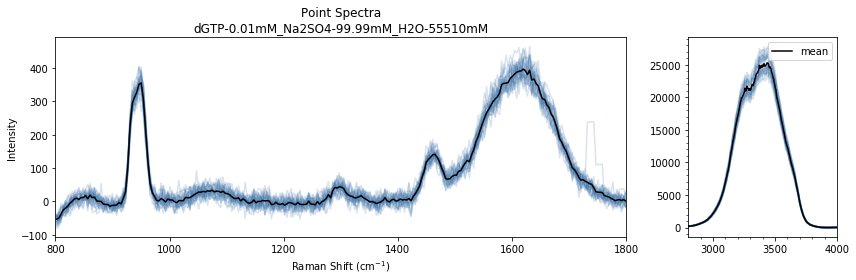


plotting dGTP-0.05mM_Na2SO4-99.95mM_H2O-55510mM, with 25 point spectra


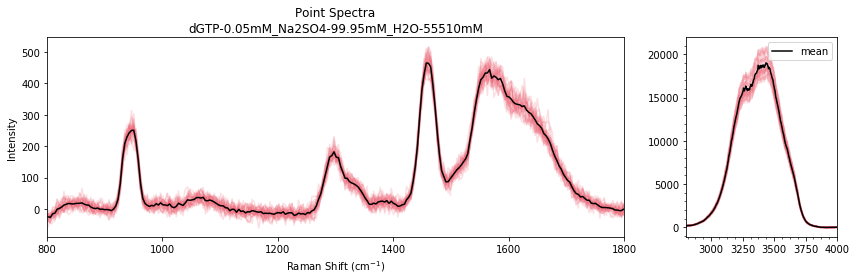


plotting dGTP-0.1mM_Na2SO4-99.9mM_H2O-55510mM, with 25 point spectra


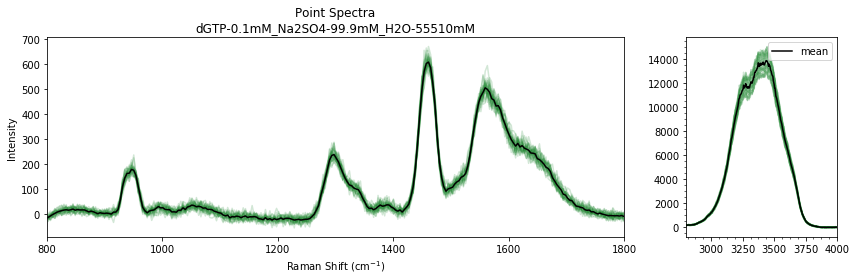


plotting dGTP-0.5mM_Na2SO4-99.5mM_H2O-55510mM, with 25 point spectra


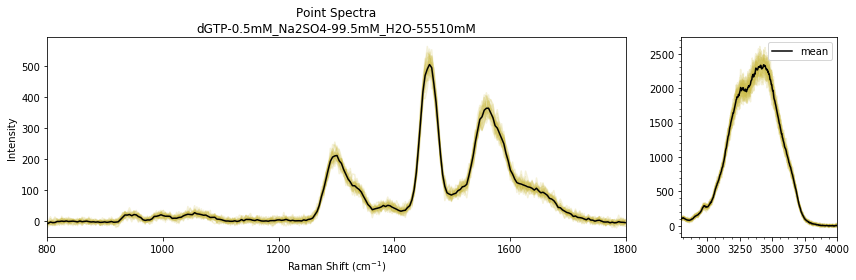


plotting dGTP-1mM_Na2SO4-99mM_H2O-55510mM, with 25 point spectra


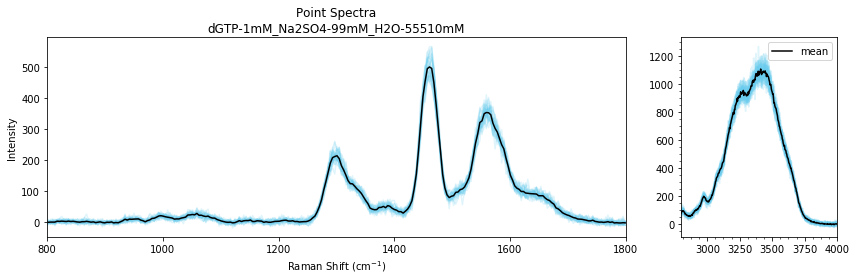


plotting dGTP-10mM_Na2SO4-90mM_H2O-55510mM, with 25 point spectra


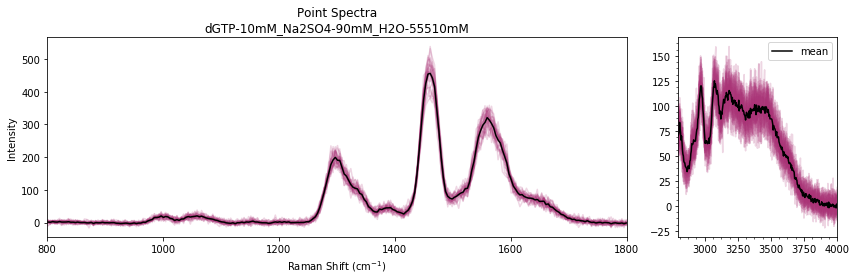


plotting dGTP-50mM_Na2SO4-50mM_H2O-55510mM, with 25 point spectra


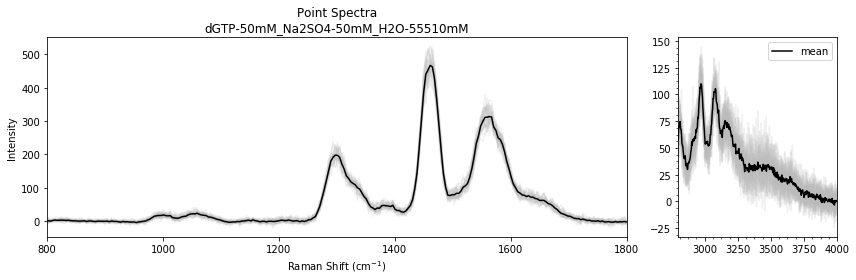

In [7]:
# skip this section?
skip = False

# set whether to print debug messages in this section
debug = False

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_sub_av_refsub'

# back-up keyname if y_key does not exist
alt_key = 'y_sub'

# label for X axis
x_label = "Raman Shift (cm$^{-1}$)"

# label for Y axis
y_label = 'Intensity'

# X range for plotting
x_start, x_end = (800, 1800)

# normalise data before plotting?
normalise = False

# offset spectra by this much (0 for no offset)
offset = 0.

# group spectra by this parameter
grouping = 'sample'

# plot average spectra?
plot_average = True

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING INTENSITY COMPARISON")
else:
    print("PLOTTING INTENSITY COMPARISONS")
    
    plot_count = 0
    for ID, measurement in data.items():
        print()
        print("plotting %s, with %s point spectra" % (measurement.title, measurement.points))
        
        count = 0

        # set up figure size
        if 'H2O' in Components:
            length = 12
        else:
            length = 8
        if offset != 0:
            height = 2 + 0.5*(measurement.points)
        else:
            height = 4
            
        # start figure
        plt.figure(figsize=(length,height))
        if 'H2O' in Components:
            ax1 = plt.subplot2grid((1,4), (0,0), colspan=3)
            ax2 = plt.subplot2grid((1,4), (0,3))
            hydration = True
            ax2.set_xlim(2800, 4000)
        ax1.set_title("Point Spectra\n%s" % measurement.title)
        ax1.set_xlabel(x_label)
        ax1.set_xlim(x_start, x_end)
        if offset > 0:
            ax1.set_ylabel(y_label)
            ax1.set_yticks([])
            if hydration == True:
                ax2.set_yticks([])
        else:
            ax1.set_ylabel(y_label)
            
        # check which key to use
        if hasattr(data[ID], y_key) == True:
            key = y_key
        else:
            key = alt_key

        # plot average spectra (if required)
        count = 0
        if plot_average == True and measurement.points > 2:
            x, y = get_plot_data(data[ID], x_key, key+"_av", start=x_start, end=x_end,
                    normalise=normalise, debug=debug)
            ax1.plot(x, y - count*offset, 'k', label='mean', zorder=3)
            
            if hydration == True:
                x, y = get_plot_data(data[ID], x_key, key+"_av", start=2800, end=4000,
                        normalise=normalise, debug=debug)
                ax2.plot(x, y - count*offset, 'k', label='mean', zorder=3)
            
        if measurement.points < 10:
            # give each spectrum its own colour
            plot_colours = [Colour_List[i % len(Colour_List)] for i in range(measurement.points)]
        else:
            # too many spectra to plot, use single colour for all
            plot_colours = np.full(measurement.points, Colour_List[plot_count % len(Colour_List)])
            
        # plot individual spectra (always)
        for i in range(measurement.points):
            
            # get data
            x, y = get_plot_data(data[ID], x_key, key, start=x_start, end=x_end, indices=[i],
                    normalise=normalise, debug=debug)
            
            # plot spectra
            if measurement.points < 10:
                # plot individual spectra as distinct lines with their own labels
                ax1.plot(x, y - count*offset, c=plot_colours[i], label="%s" % (ID))
            else:
                # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                ax1.plot(x, y - count*offset, c=plot_colours[i], alpha=1./np.sqrt(measurement.points))
            
            if hydration == True:
                # get data
                x, y = get_plot_data(data[ID], x_key, key, start=2800, end=4000, indices=[i],
                        normalise=normalise, debug=debug)

                # plot spectra
                if measurement.points < 10:
                    # plot individual spectra as distinct lines with their own labels
                    ax2.plot(x, y - count*offset, c=plot_colours[i], label="%s" % (ID))
                else:
                    # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                    ax2.plot(x, y - count*offset, c=plot_colours[i], alpha=1./np.sqrt(measurement.points))
                
            count += 1
        
        # add colorbar if required
        plt.legend(loc=1)
        plt.minorticks_on()
        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%s%s%s_point-spectra.png" % (Fig_dir, measurement.output_folder, measurement.title), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()
        
        plot_count += 1

# Peak Detection
- searches for local maxima that meet two thresholds:
    1) relative intensity (vs maximum)
    2) signal:noise ratio
- produces figure showing which maxima passed and failed
- also shows any manually specified maxima from Manual_Peaks[spec ID]

In [8]:
# skip this section?
skip = True

# print debug messages in viewer?
debug = True

# minimum signal:noise ratio threshold
SNR_threshold=10

# minimum intensity threshold relative to max
norm_threshold=0.05

# minimum peak-peak separation
min_sep=20

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_av_sub_refsub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# keyname for detected peak table
new_key ='detected-peaks'

# show plot in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING AUTOMATIC PEAK DETECTION")
else:
    print("DOING AUTOMATIC PEAK DETECTION")

    process_count = 1
    for ID, measurement in data.items():
        print()
        print("%s/%s detecting peaks for %s" % (process_count, len(data.keys()), measurement.title))

        if hasattr(measurement, y_key) == True:
            temp = y_key
        else:
            temp = alt_key

        detect_peaks(measurement, x_key, temp, new_key, SNR_threshold=SNR_threshold,
                     norm_threshold=norm_threshold, min_sep=min_sep, show_plot=show_plot, save_plot=save_plot,
                     debug=debug)
        process_count += 1
        print("    done!")

SKIPPING AUTOMATIC PEAK DETECTION


# Peak Fitting
- fits peaks using mathematical functions, choose from:
    - PV: pseudo-voigt (linear mix of gaussian & lorentzian, recommended for most Raman spectra)
    - G: gaussian (default)
    - L: lorentzian
    - FD: symmetric fermi-dirac (not recommended except in extreme cases)
- will use manually specified peak positions for each spec ID in Manual_Peaks, or Default peak positions if listed. If no peaks are listed, uses peaks from peak detection instead
- spectra will be divided into regions to be fitted separately, based on how far apart peaks are
    - use the fit_window setting to change the max separation

In [9]:
# skip this section?
skip = True

# print debug messages in viewer?
debug = False

# function for peak fitting, choose from 'G', 'L', 'PV', or 'FD'
Fit_Function = 'PV'

# a list of peak positions to fit for each spec ID, leave empty to use automatically detected peaks
Manual_Peaks = {
}

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_av_sub_refsub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# keyname for detected peak table
new_key ='fitted-peaks'

# show plot in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING AUTOMATIC PEAK FITTING")
else:
    print("DOING AUTOMATIC PEAK FITTING")

    if len(Spec_IDs) == 0:
        print("    no spectra imported, skipping")

    process_count = 1
    for ID, measurement in data.items():
        title = measurement.title
        sample = measurement.sample
        print()
        print("%s/%s fitting peaks for %s" % (process_count, len(data.keys()), measurement.title))

        if hasattr(measurement, y_key) == True:
            temp = y_key
        else:
            temp = alt_key

        if ID in Manual_Peaks:
            positions = Manual_Peaks[ID]
            print("    specified peaks:", ", ".join(["%0.f" % i for i in positions]))
        elif hasattr(measurement, 'detected-peaks'):
            positions = measurement['detected-peaks'].loc[:,'centers']
            print("    detected peaks:", ", ".join(["%0.f" % i for i in positions]))
        else:
            positions = []
            print("    no peak positions specified")

        fit_peaks(measurement, x_key, temp, new_key, function=Fit_Function, peak_positions=positions,
                  show_plot=show_plot, save_plot=save_plot, debug=debug)
        process_count += 1
        print("    done!")

SKIPPING AUTOMATIC PEAK FITTING


# Compare Samples with the same label
- this section groups spectra according to a specified property and plots comparison figures for each group

PLOTTING SAMPLE COMPARISONS

1 groups found: ['dGTP/Na2SO4/H2O']

plotting group dGTP/Na2SO4/H2O, 7 spectra found


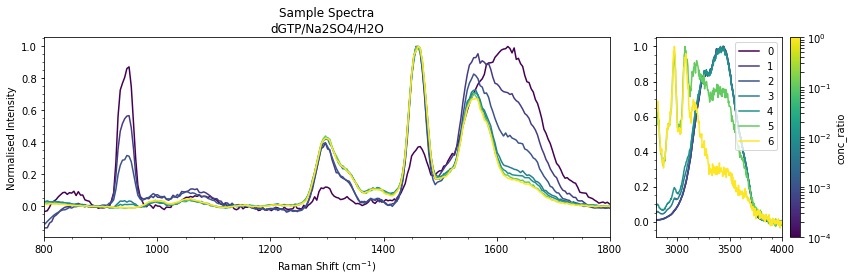

In [10]:
# skip this section?
skip = False

# set whether to print debug messages in this section
debug = False

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_av_sub_refsub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# label for X axis
x_label = "Raman Shift (cm$^{-1}$)"

# label for Y axis
y_label = 'Normalised Intensity'

# X range for plotting
x_start, x_end = (800, 1800)

# normalise data before plotting?
normalise = True

# offset spectra by this much (0 for no offset)
offset = 0.

# group spectra by this parameter
grouping = 'sample'

# plot average spectra?
plot_average = False

# property to use for colour mapping
colour_by = 'conc_ratio'
colour_norm = 'log'

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING SAMPLE COMPARISON")
else:
    print("PLOTTING SAMPLE COMPARISONS")

    # get groupings
    groups = list(np.unique([measurement[grouping] for ID, measurement in data.items() if hasattr(measurement, grouping)]))
    print()
    print("%s groups found:" % len(groups), groups)
    
    # plot spectra for each group separately
    for group in groups:
        result = [ID for ID, measurement in data.items() if getattr(measurement, grouping, "") == group]
        spec_count = len(result)
        print()
        print("plotting group %s, %s spectra found" % (group, spec_count))
        if debug == True:
            print("    ", result)
        
        count = 0

        # set up figure size
        if 'H2O' in Components:
            length = 12
        else:
            length = 8
        if offset != 0:
            height = 2 + len(result)
        else:
            height = 4
            
        # start figure
        plt.figure(figsize=(length,height))
        if 'H2O' in Components:
            ax1 = plt.subplot2grid((1,4), (0,0), colspan=3)
            ax2 = plt.subplot2grid((1,4), (0,3))
            hydration = True
            ax2.set_xlim(2800, 4000)
        ax1.set_title("Sample Spectra\n%s" % group)
        ax1.set_xlabel(x_label)
        ax1.set_xlim(x_start, x_end)
        if offset > 0:
            ax1.set_ylabel(y_label)
            ax1.set_yticks([])
            if hydration == True:
                ax2.set_yticks([])
        else:
            ax1.set_ylabel(y_label)

        # plot average spectra (if required)
        count = 0
        if plot_average == True and spec_count > 1:
            x, y = average_spectra([data[ID] for ID in result], x_key, y_key, alt_key, start=x_start, end=x_end,
                                  normalise=normalise, debug=debug)
            ax1.plot(x, y - count*offset, 'k', label='mean', zorder=3)
            if hydration == True:
                ax2.plot(x, y - count*offset, 'k', label='mean', zorder=3)
            
        # generate colour map
        cmap_yesno = False
        if colour_by in ['conc_ratio']:
            # generate colour map based on sample/measurement property
            temp = np.asarray([getattr(data[ID], colour_by, np.nan) for ID in result])
            if colour_norm == 'log':
                check = np.logical_and(~np.isnan(temp), temp > 0)
                norm = mpl.colors.LogNorm(vmin=10**np.floor(np.log10(np.nanmin(temp[check]))),
                                          vmax=10**np.ceil(np.log10(np.nanmax(temp[check]))))
            else:
                norm = mpl.colors.Normalize(vmin=np.nanmin(temp), vmax=np.nanmax(temp))
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
            cmap.set_array([])
            plot_colours = cmap.to_rgba(temp)
            cmap_yesno = True
        elif len(result) > 10:
            # too many spectra to plot, use group colour for all
            plot_colours = np.full(len(result), Colour_List[groups.index(group) % len(Colour_List)])
        else:
            # give each spectrum its own colour
            plot_colours = [Colour_List[i % len(Colour_List)] for i in range(len(result))]
            
        # plot individual spectra (always)
        for i, ID in enumerate(result):
            # check which key to use
            if hasattr(data[ID], y_key) == True:
                key = y_key
            else:
                key = alt_key
            
            # get data
            x, y = get_plot_data(data[ID], x_key, key, start=x_start, end=x_end,
                    normalise=normalise, debug=debug)
            
            # plot spectra
            if len(result) < 10:
                # plot individual spectra as distinct lines with their own labels
                ax1.plot(x, y - count*offset, c=plot_colours[i], label="%s" % (ID))
            else:
                # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                ax1.plot(x, y - count*offset, c=plot_colours[i])
            
            if hydration == True:
                # get data for hydration range
                x, y = get_plot_data(data[ID], x_key, key, start=2800, end=4000,
                        normalise=normalise, debug=debug)
                
                # plot spectra
                if len(result) < 10:
                    # plot individual spectra as distinct lines with their own labels
                    ax2.plot(x, y - count*offset, c=plot_colours[i], label="%s" % (ID))
                else:
                    # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                    ax2.plot(x, y - count*offset, c=plot_colours[i])

            count += 1
        
        # add colorbar if required
        if cmap_yesno == True:
            plt.colorbar(cmap, label=colour_by)
        plt.legend(loc=1)
        ax1.minorticks_on()
        if hydration == True:
            ax2.minorticks_on()
        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%s%s/%s_spectra.png" % (Fig_dir, Mixture, Mixture), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()

# Plot Intensities vs Concentration

PLOTTING INTENSITIES

1 groups found: ['dGTP/Na2SO4/H2O']

plotting group dGTP/Na2SO4/H2O, 7 spectra found

peaks to plot: [950, 1460, 1560, 3400]
4x3: 0 x 1 -> 3 x 2
4x3: 0 x 2 -> 3 x 1
4x3: 0 x 3 -> 3 x 0
4x3: 1 x 2 -> 2 x 1
4x3: 1 x 3 -> 2 x 0
4x3: 2 x 3 -> 1 x 0


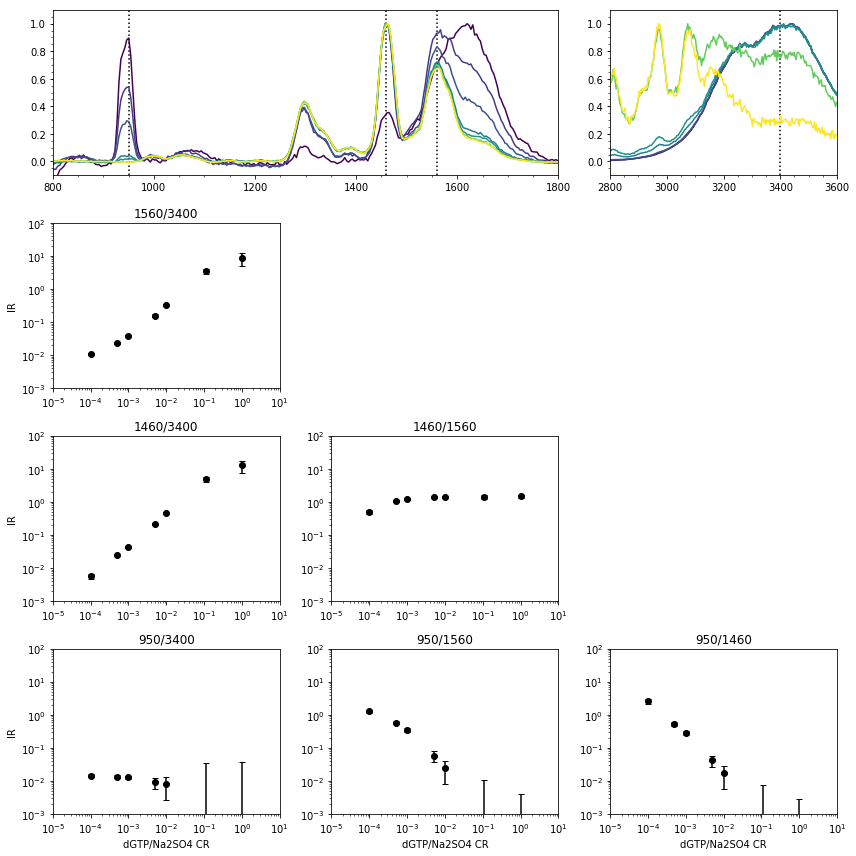

In [11]:
# skip this section?
skip = False

# set whether to print debug messages in this section
debug = False

from itertools import combinations

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_sub_refsub'

# back-up keyname if y_key does not exist
alt_key = 'y_sub'

# group spectra by this parameter
grouping = 'sample'

# X range for plotting
x_start, x_end = (800, 1800)

# property to use for colour mapping
colour_by = 'conc_ratio'
colour_norm = 'log'

# offset spectra
offset = 0.

#
positions = {
    'dATP': [1300, 1560],
    'dCTP': [1510, 1625],
    'dGTP': [1460, 1560],
    'dTTP': [1350, 1635],
    'Na2SO4': [950],
    'H2O': [3400]
}

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING INTENSITY PLOT")
else:
    print("PLOTTING INTENSITIES")

    # get groupings
    groups = list(np.unique([measurement[grouping] for ID, measurement in data.items() if hasattr(measurement, grouping)]))
    print()
    print("%s groups found:" % len(groups), groups)
    
    # plot spectra for each group separately
    for group in groups:
        result = [ID for ID, measurement in data.items() if getattr(measurement, grouping, "") == group]
        spec_count = len(result)
        print()
        print("plotting group %s, %s spectra found" % (group, spec_count))
        if debug == True:
            print("    ", result)
        
        # pick peak positions based on components
        peaks = []
        for comp in Components:
            peaks += positions[comp]
        peaks = sorted(peaks)
        print()
        print("peaks to plot:", peaks)
        
        # create ragged storage array for intensity values
        intensities = []
        for peak in peaks:
            intensities.append([])
            
        # get intensities
        conc_ratios = np.asarray([getattr(data[ID], 'conc_ratio', np.nan) for ID in result])
        for ID in result:
            # check which key to use
            if hasattr(data[ID], y_key) == True:
                key = y_key
            else:
                key = alt_key
                
            x, y = data[ID](x_key, key)
            
            for i, peak in enumerate(peaks):
                intensities[i].append(y[np.argmin(np.abs(x - peak)),:])
        
        # create figure
        fig_size = len(peaks)
        plt.figure(figsize=(3*fig_size, 3*(fig_size)))
        
        # create subplots for spectra
        if 'H2O' in Components:
            hydration = True
            ax1 = plt.subplot2grid((fig_size, fig_size-1), (0,0), colspan=fig_size-2)
            ax2 = plt.subplot2grid((fig_size, fig_size-1), (0,fig_size-2))
        else:
            hydration = False
            ax1 = plt.subplot2grid((fig_size, fig_size-1), (0,0), colspan=fig_size-1)
        ax1.set_xlim(x_start, x_end)
        ax1.set_ylim(-0.1, 1.1)
        ax1.minorticks_on()
        if hydration == True:
            ax2.set_xlim(2800, 3600)
            ax2.set_ylim(-0.1, 1.1)
            ax2.minorticks_on()
        for peak in peaks:
            if x_start < peak and peak < x_end:
                ax1.axvline(peak, color='k', linestyle=':')
            if hydration == True:
                if 2800 < peak and peak < 3600:
                    ax2.axvline(peak, color='k', linestyle=':')
            
        # generate colour map
        cmap_yesno = False
        if colour_by in ['conc_ratio']:
            # generate colour map based on sample/measurement property
            temp = np.asarray([getattr(data[ID], colour_by, np.nan) for ID in result])
            if colour_norm == 'log':
                check = np.logical_and(~np.isnan(temp), temp > 0)
                norm = mpl.colors.LogNorm(vmin=10**np.floor(np.log10(np.nanmin(temp[check]))),
                                          vmax=10**np.ceil(np.log10(np.nanmax(temp[check]))))
            else:
                norm = mpl.colors.Normalize(vmin=np.nanmin(temp), vmax=np.nanmax(temp))
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
            cmap.set_array([])
            plot_colours = cmap.to_rgba(temp)
            cmap_yesno = True
        elif len(result) > 10:
            # too many spectra to plot, use group colour for all
            plot_colours = np.full(len(result), Colour_List[groups.index(group) % len(Colour_List)])
        else:
            # give each spectrum its own colour
            plot_colours = [Colour_List[i % len(Colour_List)] for i in range(len(result))]
            
        # plot spectra
        for i, ID in enumerate(result):
            x, y = get_plot_data(data[ID], x_key, key+"_av", start=x_start, end=x_end,
                    normalise=True, debug=debug)
            if len(result) < 10:
                # plot individual spectra as distinct lines with their own labels
                ax1.plot(x, y, c=plot_colours[i], label="%s" % (ID))
            else:
                # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                ax1.plot(x, y, c=plot_colours[i])

            if hydration == True:
                # get data for hydration range
                x, y = get_plot_data(data[ID], x_key, key+"_av", start=2800, end=4000,
                        normalise=True, debug=debug)
                # plot spectra
                if len(result) < 10:
                    # plot individual spectra as distinct lines with their own labels
                    ax2.plot(x, y, c=plot_colours[i], label="%s" % (ID))
                else:
                    # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                    ax2.plot(x, y, c=plot_colours[i])
        
        # get limits
        check = np.logical_and(~np.isnan(conc_ratios), conc_ratios > 0)
        x_min = 10**(np.floor(np.log10(0.9*np.nanmin(conc_ratios[check]))))
        x_max = 10**(np.ceil(np.log10(1.1*np.nanmax(conc_ratios[check]))))
        temp = []
        pairs = combinations(range(len(peaks)), 2)
        for pair in pairs:
            xi, yi = pair
            int1 = np.mean(intensities[xi], axis=1)
            int2 = np.mean(intensities[yi], axis=1)
            temp.append(int1 / int2)
        temp = np.ravel(temp)
        check = np.logical_and(~np.isnan(temp), temp > 0)
        y_min = 10**(np.floor(np.log10(0.9*np.nanmin(temp[check]))))
        y_max = 10**(np.ceil(np.log10(1.1*np.nanmax(temp[check]))))
        
        # plot intensity ratios
        pairs = combinations(range(len(peaks)), 2)
        for pair in pairs:
            xi, yi = pair
            x_pos = peaks[xi]
            y_pos = peaks[yi]
            print("%sx%s: %s x %s -> %s x %s" % (fig_size, fig_size-1, xi, yi, fig_size-1-xi, fig_size-1-yi))
            plt.subplot2grid((fig_size, fig_size-1), (fig_size-1-xi, fig_size-1-yi))
            plt.title("%s/%s" % (x_pos, y_pos))
            
            int1 = np.mean(intensities[xi], axis=1)
            err1 = np.std(intensities[xi], axis=1)
            int2 = np.mean(intensities[yi], axis=1)
            err2 = np.std(intensities[yi], axis=1)
            int_ratios = int1 / int2
            int_ratios_err = int_ratios * np.sqrt((err1 / int1)**2 + (err2 / int2)**2)
            
            plt.errorbar(conc_ratios, int_ratios, yerr=int_ratios_err, fmt='none', color='k', capsize=3)
            plt.scatter(conc_ratios, int_ratios, c='k')
            plt.xlim(x_min, x_max)
            plt.xscale('log')
            plt.ylim(y_min, y_max)
            plt.yscale('log')
            if yi == fig_size-1:
                plt.ylabel("IR")
            if xi == 0:
                plt.xlabel("%s/%s CR" % (Components[0], Components[1]))
            
        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%s%s/%s_raw-intensities.png" % (Fig_dir, Mixture, Mixture), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()

# Save Processed Spectra
- for all measurements, the average spectrum is saved to _av-spectrum.csv
    - includes columns for raw intensity, baselined intensity, and normalised values
- for multi-spec measurements (e.g. maps and line-scans), all point-spectra are saved to _all-spectra_baselined.csv
    - each spectrum is saved as a column along with its X,Y coordinates

In [12]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = False

# save metadata to dedicated file? (recommended)
save_metadata = True
    
if skip == True:
    print("SKIPPING SAVE TO FILE STEP")
else:
    print("SAVING PROCESSED SPECTRA TO OUTPUT FOLDER")

    process_count = 1
    for ID, measurement in data.items():
        title = measurement.title
        print()
        print("%s/%s saving spectrum %s" % (process_count, len(data.keys()), measurement.title))

        # one column for each modification of spectrum
        headers = ['Wavelength (nm)', 'Raman Shift (cm-1)', 'Raw Intensity', 'Normalised Intensity',
                   'Baselined Intensity', 'Normalised Baselined Intensity']
        if hasattr(measurement, 'y_av_sub_refsub'):
            print("    using y_av_sub_refsub")
            print("        log:", ", ".join(measurement['y_av_sub_refsub'].log))
            keys = ['wavelength', 'raman_shift', 'y_av', 'y_av_norm', 'y_av_sub_refsub', 'y_av_sub_refsub_norm']
        else:
            print("    using y_av_sub")
            keys = ['wavelength', 'raman_shift', 'y_av', 'y_av_norm', 'y_av_sub', 'y_av_sub_norm']
        save_measurement(measurement, keys=keys, headers=headers, save_name='av-spectrum', debug=debug)

        # save all point-spectra to file (maps & multi-spec files only)
        if measurement.points > 1 and hasattr(measurement, 'y_sub'):
            # one column per baselined point-spectrum
            headers = ['Wavelength (nm)', 'Raman Shift (cm-1)', 'Baselined Intensity']
            keys = ['wavelength', 'raman_shift', 'y_sub']
            save_measurement(measurement, keys=keys, headers=headers, save_name='all-spectra-baselined', debug=debug)
        process_count += 1
        print("    saved!")

SAVING PROCESSED SPECTRA TO OUTPUT FOLDER

1/7 saving spectrum dGTP-0.01mM_Na2SO4-99.99mM_H2O-55510mM
    using y_av_sub
    saved!

2/7 saving spectrum dGTP-0.05mM_Na2SO4-99.95mM_H2O-55510mM
    using y_av_sub
    saved!

3/7 saving spectrum dGTP-0.1mM_Na2SO4-99.9mM_H2O-55510mM
    using y_av_sub
    saved!

4/7 saving spectrum dGTP-0.5mM_Na2SO4-99.5mM_H2O-55510mM
    using y_av_sub
    saved!

5/7 saving spectrum dGTP-1mM_Na2SO4-99mM_H2O-55510mM
    using y_av_sub
    saved!

6/7 saving spectrum dGTP-10mM_Na2SO4-90mM_H2O-55510mM
    using y_av_sub
    saved!

7/7 saving spectrum dGTP-50mM_Na2SO4-50mM_H2O-55510mM
    using y_av_sub
    saved!


In [13]:
print("SCRIPT COMPLETE!")

SCRIPT COMPLETE!
